of course we know that there are more things that affects the price of a certain product, but in this project we'll look only at the nutrition values of the products

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)

In [3]:
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [5]:
df.replace('(^\s+|\s+$)', '', regex=True, inplace=True)
df= df.set_index('Product_Name')

In [6]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

In [7]:
dfprod = train_set.copy()

In [8]:
for col in df.columns:  
    dfprod[col] = pd.to_numeric(dfprod[col], errors='coerce')
dfprod = dfprod.fillna(0)
dfprod = dfprod.loc[:, (df != 0).any(axis=0)]

In [9]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rif of all the products that are not measured by 100_g or 1_kg (and delete the columns of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [10]:
#first, we'll find the products without the wanted price units 
unwanted_units = dfprod[(dfprod['100_g']==0) & (dfprod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(dfprod[(dfprod['100_g']!=0) & (dfprod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
dfprod = dfprod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(dfprod.loc[:, (dfprod == 0).all(axis=0)]).index
dfprod = dfprod.loc[:, (dfprod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
dfprod['1_kg'] = dfprod['1_kg']/10
dfprod['price_per_100g'] = dfprod['1_kg'] + dfprod['100_g']
dfprod = dfprod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [11]:
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Unsaturated', 'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA',
       'Chlorophyll'],
      dtype='object')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

Before we continued to work with the data, we wanted to scale the data in order to avoid ay problems that might come with nutrition values that are measured by different units.

### uniting the desired columns:

In [12]:
def merge_two_columns(col1, col2, dataframe, index_col):
    dataframe = dataframe.reset_index()
    row = 0
    for prod in dataframe[col1]:
        if (prod==0):
            if (dataframe.at[row , col2]!=0):
                dataframe.at[row, col1] =  dataframe.at[row ,col2]  
        row = row+1
    dataframe = dataframe.drop([col2], axis = 1)
    dataframe = dataframe.set_index(index_col, drop=True)
    return dataframe

In [13]:
dfprod = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dfprod, 'Product_Name')
dfprod = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dfprod, 'Product_Name')
dfprod = merge_two_columns('potassium', 'K_Potassium', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_B3', 'Niacin', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_B3', 'Vitamin_B3_Nicotinamide_Equilibrium', dfprod, 'Product_Name')

### creating another data set:

Before we started making changes, we wanted to look at the amount data we have from each nutrition value, beacuse logicly, the nutrition values we have more can help us predict the price to a wider range of products.

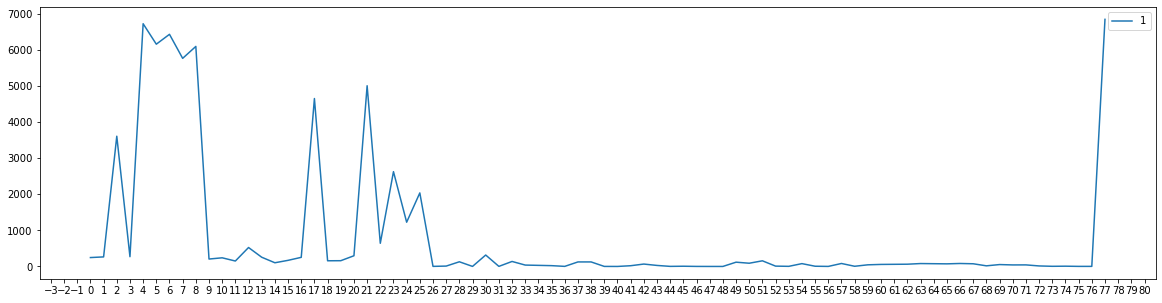

In [14]:
df_num = []
df_name = []
for col in dfprod.columns:
    df_num.append(int(dfprod[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Dynamically finds major tick positions
plta.gcf().set_size_inches(20, 5)
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 20, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

we can see from the graph that the mass of products we have with more than 1000 non-zero values is between columns 2 to 26. Based on that, we created a new data set of only these features and the price columns.

In the end, when we tried to run the models we decided what kind of filltering is the most worthy, and which features are better for predictions (what feature selection we should do)

In [15]:
dfprod2 = dfprod.iloc[:,2:26] 
dfprod2['price_per_100g'] = dfprod['price_per_100g']
dfprod2

,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,sodium,Vitamin_B3,potassium,Vitamin_C,...,Carbohydrate_sugars,Vitamin_A,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium,Cholesterol,price_per_100g
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.00,89.00,0.80,9.20,6.30,17.5,0.0,0,0.0,...,0.0,0.0,0.0,0.0,3.30,0.00,0.00,0.0,0.0,4.95
Pasta_Perfecto_Casserole,1.60,0.00,160.00,0.00,0.00,0.00,0.0,0.0,0,0.0,...,1.4,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.38
Whole_champignon_mushrooms,2.20,0.00,18.00,2.10,0.90,0.00,240.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.65
Light_bread_from_whole_spelled,2.45,0.00,38.88,3.07,8.46,0.39,86.9,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.12,0.00,0.00,0.0,0.0,3.90
Baby_bite_flavored_vegetables,0.00,0.00,8.00,0.00,2.00,0.00,6.0,0.0,0,0.0,...,0.3,0.0,0.0,0.0,0.10,0.00,0.00,0.0,0.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,0.00,335.00,6.30,76.00,0.00,0.0,0.0,0,0.0,...,45.0,0.0,0.0,0.0,0.00,0.00,11.25,0.0,0.0,9.86
Slim_Delis_Multi-Grain_Milk,1.60,7.22,59.00,0.80,7.40,2.60,36.4,0.7,0,0.0,...,4.4,34.5,0.0,0.0,1.40,0.00,8.75,0.0,0.0,9.08
Chocolate_with_popsicles,0.00,0.00,516.00,8.10,58.00,27.00,117.0,0.0,0,0.0,...,57.0,0.0,0.0,0.0,16.50,0.00,14.25,0.0,29.0,6.11


### checking the correlations:

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

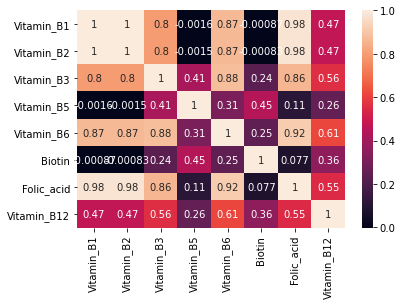

In [16]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = dfprod.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV, annot=True)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 - by the bright orange colour (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of these columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the most products in it (the Vitamin with the most products in a better representetive of the data)
- the one with the biggest correlation with column we want to predict - price_per_100g

In [17]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B3', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = dfprod["price_per_100g"]
    column_2 = dfprod[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print(rep, ": number of products that has value: ", dfprod[rep].astype(bool).sum(axis=0))
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  2
Vitamin_B1 : number of products that has value:  247
correlation between price_per_100g and  Vitamin_B1 :  0.017850331414698644
Vitamin_B3 : number of correlations that are greater than 0.8:  3
Vitamin_B3 : number of correlations that are below or equal 0.2:  0
Vitamin_B3 : number of products that has value:  206
correlation between price_per_100g and  Vitamin_B3 :  0.037083577193226025
Vitamin_B6 : number of correlations that are greater than 0.8:  5
Vitamin_B6 : number of correlations that are below or equal 0.2:  0
Vitamin_B6 : number of products that has value:  265
correlation between price_per_100g and  Vitamin_B6 :  0.030040150886635707
Folic_acid : number of correlations that are greater than 0.8:  5
Folic_acid : number of correlations that are below or equal 0.2:  2
Folic_acid : number of products that has value:  271
correlation between price_p

By the two firet criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 5), and it has the smallest number of correlations that are below or equal 0.2 (which is 0). Although Vitamin_B6 dosen't have the biggest correlation between price_per_100g, it has the second biggest one, and the difference between them is not that big.

We thought that we had a problem - the fact that in the Vitamin_B6 there are only 265 products, which is less than 5 precent of our data (it's about three precents - dfprod has 7668 products).

So we tried a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B3 (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well). Afterwards there was be Vitamin_B9 (Folic_acid) with the next best correlation after the two before and the biggest number of correlations that are greater than 0.8 and then Vitamin_B1. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Biotin and Vitamin_B5 because we can see from the graph that the correlation between Biotin, Vitamin_B5 and the other of the Vitamins is low.

we tried a different combinations of the code that appears in the next window, but it seemed that anything we did made the correlation between the column we tried to create to the price_per_100g to get lower and lower.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B12 who had lower correlations with the rest of the Vitamin Bs' group, so we wanted to look further into them.

In [18]:
dfprod['Partof_vitaminB'] = dfprod['Vitamin_B6']

In [19]:
#example to one of the combinations we tried to do:
dfprod['Vitamin_B_group'] = dfprod['Vitamin_B6']
dfprod = merge_two_columns('Vitamin_B_group', 'Vitamin_B3', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_B_group', 'Folic_acid', dfprod, 'Product_Name')        
dfprod = merge_two_columns('Vitamin_B_group', 'Vitamin_B1', dfprod, 'Product_Name')  
column_1 = dfprod["price_per_100g"]
column_2 = dfprod['Vitamin_B_group']
correlation = column_1.corr(column_2)
print(correlation)
print(dfprod['Vitamin_B_group'].astype(bool).sum(axis=0))
dfprod = dfprod.drop(['Vitamin_B2', 'Vitamin_B6'], axis=1)
#it's only for documantation and show, so we'll drop this column
dfprod = dfprod.drop(['Vitamin_B_group'], axis=1)

-0.007774906132561432
303


In [20]:
corr_matrix = dfprod.corr()
corr_matrix['Vitamin_B12'].sort_values(ascending=False)

Vitamin_B12             1.000000
Partof_vitaminB         0.613192
Biotin                  0.359965
Vitamin_E.              0.282495
Vitamin_B5              0.257006
                          ...   
Trans_fatty_acids      -0.010597
Of_which_added_sugar   -0.012984
Cholesterol            -0.014627
Carbohydrate_sugars    -0.015561
Teaspoons_of_sugar     -0.029171
Name: Vitamin_B12, Length: 74, dtype: float64

In [21]:
corr_matrix = dfprod.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5              1.000000
Vitamin_K.              0.486277
copper                  0.481449
Vitamin_E.              0.471459
Inositol                0.466317
                          ...   
Cholesterol            -0.010968
Trans_fatty_acids      -0.011093
Of_which_added_sugar   -0.012517
sodium                 -0.015372
Fats                   -0.030935
Name: Vitamin_B5, Length: 74, dtype: float64

In [22]:
corr_matrix = dfprod.corr()
corr_matrix['Biotin'].sort_values(ascending=False)
#the only connection found between biotin and vitamin e is: both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin                   1.000000
Vitamin_E.               0.538266
Vitamin_B5               0.446249
Vitamin_K.               0.402509
copper                   0.390171
                           ...   
Saturated_fatty_acids   -0.005698
Of_which_added_sugar    -0.007244
Proteins                -0.007313
Fats                    -0.008451
sodium                  -0.010015
Name: Biotin, Length: 74, dtype: float64

The highest correlation Vitamin_B12 has with anything is with the Partof_vitaminB column we made. Thus, we decided to can give up on this column as well(to be represented by the Partof_vitaminB column). Moreover, the highest correlations that Biotin and Vitamin_B5 has with any other feature is a week relationship (absolute value between 0.25 and 0.5).

Furthermore, because we such a succsess with choosing the representitive of the Vitamin B group, we decided we wanted to look for a correlation within all the vitamin groups.

In [23]:
dfprod = dfprod.drop(['Vitamin_B12'], axis = 1)
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.' ,'Partof_vitaminB', 'Biotin', 'Vitamin_B5', 'price_per_100g']
vitaminS = dfprod.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
corrvl['Vitamin_K.'].sort_values(ascending=False)

Vitamin_K.         1.000000
Vitamin_A          0.565932
Vitamin_E.         0.504205
Vitamin_B5         0.486277
Vitamin_D.         0.452447
Vitamin_C          0.432278
Biotin             0.402509
Partof_vitaminB    0.131602
price_per_100g     0.019254
Name: Vitamin_K., dtype: float64

There isn't a particulater high correlation. There is a weak connection between them all, but we can attribute that to the fact that a lot of the times vitamin appears together in the same kinds of foods (such as fruits).

###### checking correlations between all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

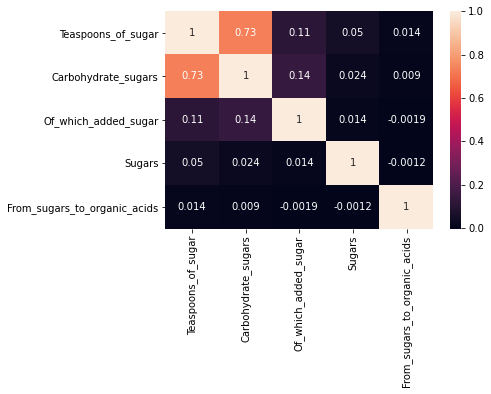

In [24]:
corr_matrix = dfprod.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars', 'From_sugars_to_organic_acids']
Sugars_matix = dfprod.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS,annot=True)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [25]:
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["Teaspoons_of_sugar"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and Teaspoons_of_sugar ", correlation)
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and the price per 100g ", correlation)
column_1 = dfprod["Teaspoons_of_sugar"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation between Teaspoons of sugar and the price per 100g ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.45552970465369486
correlation between Carbohydrate_sugars and Teaspoons_of_sugar  0.7301588432352357
correlation between Carbohydrate_sugars and the price per 100g  0.024584295050148187
correlation between Teaspoons of sugar and the price per 100g  0.035842960679840864


The correlation between Carbohydrate_sugars and Teaspoons_of_sugar is indeed about 0.8 (0.73), and id higher than the correlation between Carbohydrates and Carbohydrate_sugars, which is due to the fact that in the labeling itself, some of the Carbohydrates are Carbohydrate_sugars (as we learn from LJ Amaral, R.D., a registered dietician in https://greatist.com/health/relationship-between-sugar-and-carbs#What-You-Need-to-Know-About-Sugar-and-Carbohydrates-). 

In every product there is a different amount of sugar, and thus the correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [26]:
dfprod = dfprod.drop(['Carbohydrate_sugars'], axis=1)

###### checking correlations between energy and the rest of the nutrition values:

In [27]:
corr_matrix = dfprod.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False))

energy                 1.000000
Fats                   0.755192
Carbohydrates          0.438575
Teaspoons_of_sugar     0.309344
Dietary_fiber          0.219598
                         ...   
Linoleic_fatty_acid   -0.049040
Vitamin_C             -0.052495
chlorine              -0.052922
ARA_fatty_acid        -0.056550
sodium                -0.116058
Name: energy, Length: 72, dtype: float64


The strong correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9 

In [28]:
column_1 = dfprod["energy"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = dfprod["Fats"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
dfprod = dfprod.drop(['energy'], axis=1) #the correlation with Fats is higher. thus, we'll drop the energy column

correlation with energy  0.03748325030418607
correlation with Fats  0.08301467929792973


###### checking correlations between the many kinds of fat: 
(we'll just point out that Linoleic_fatty_acid and Alpha_Linolenic_Acid are not the same fat acid. In they're compound, Linoleic_fatty_acid has 2 more hydrogen than Alpha_Linolenic_Acid)

Alpha_Linolenic_Acid(ALA)'s compound: C18H30O2 (https://en.wikipedia.org/wiki/Alpha-Linolenic_acid)

Linoleic_fatty_acid's compound: C18H32O2 (https://en.wikipedia.org/wiki/Linoleic_acid)

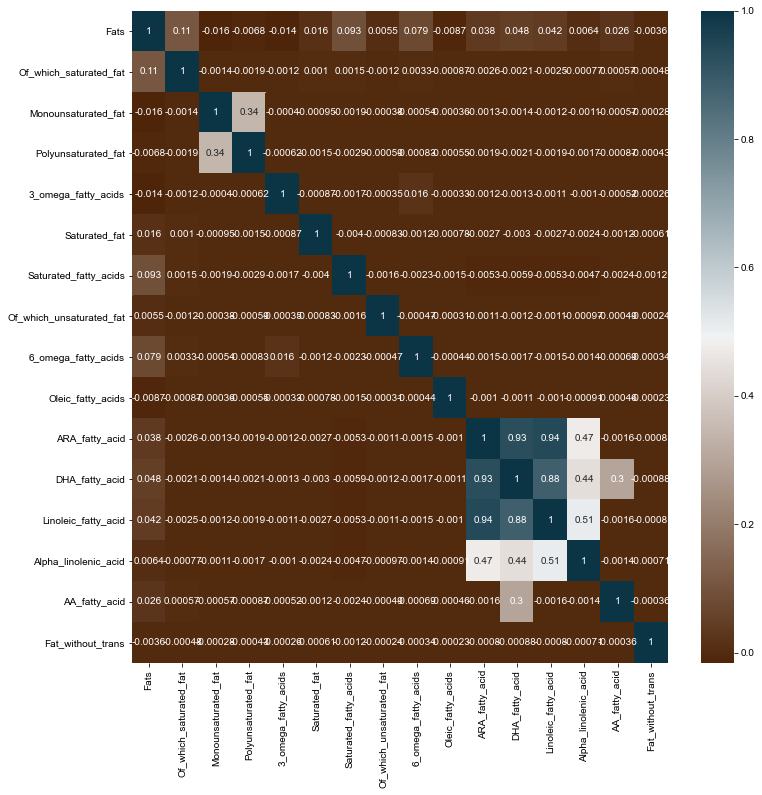

In [29]:
Ft = ['Fats','Of_which_saturated_fat','Monounsaturated_fat','Polyunsaturated_fat','3_omega_fatty_acids',
             'Saturated_fat','Saturated_fatty_acids','Of_which_unsaturated_fat','6_omega_fatty_acids','Oleic_fatty_acids'
             ,'ARA_fatty_acid', 'DHA_fatty_acid','Linoleic_fatty_acid','Alpha_linolenic_acid','AA_fatty_acid','Fat_without_trans']
Fats_list = dfprod.loc[:,Ft]
cmap = sns.diverging_palette(30, 230, 90, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(Fats_list.corr(),annot=True, cmap=cmap)
sns.set(font_scale=1)

we can see from graph that there is an area with a high correlation between three features - ARA_fatty_acid, DHA_fatty_acid and Linoleic_fatty_acid. The higher correlations are with ARA_fatty_acid so we decided to dig further in the origins of ARA_fatty_acid. 

we found out that Linoleic acid, AA_fatty_acid, ARA_fatty_acid (apperaantly AA_fatty_acid and ARA_fatty_acid is the same fatty_acid) are subsets of 6_omega_fatty_acids https://en.wikipedia.org/wiki/Omega-6_fatty_acid

We decided to unite these columns, but not before we checked does some of the fats we have are subsets of 3_omega_fatty_acids. we descovered that DHA_fatty_acid together with ALA (which is Alpha_Linolenic_Acid) are subsets of 3_omega_fatty_acids.https://en.wikipedia.org/wiki/Omega-3_fatty_acid

Also, we found that there is a connection between linoleic acids and oleic acids.

In [30]:
dfprod = merge_two_columns('6_omega_fatty_acids', 'AA_fatty_acid', dfprod, 'Product_Name')
dfprod = merge_two_columns('6_omega_fatty_acids', 'ARA_fatty_acid', dfprod, 'Product_Name')
dfprod = merge_two_columns('6_omega_fatty_acids', 'Linoleic_fatty_acid', dfprod, 'Product_Name')
dfprod = merge_two_columns('3_omega_fatty_acids', 'DHA_fatty_acid', dfprod, 'Product_Name')
dfprod = merge_two_columns('3_omega_fatty_acids', 'Alpha_linolenic_acid', dfprod, 'Product_Name')

After we accomplished all of our goals from the beginning and in that preapered the data, we wanted to choose a performance measure. for a regression project, like ours there are a few performance measure. we chose to use R^2 and RMSE


In [31]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6839 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 66 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Dietary_fiber                        6839 non-null   float64
 1   Proteins                             6839 non-null   float64
 2   Carbohydrates                        6839 non-null   float64
 3   Fats                                 6839 non-null   float64
 4   sodium                               6839 non-null   float64
 5   potassium                            6839 non-null   int64  
 6   Vitamin_C                            6839 non-null   float64
 7   iron                                 6839 non-null   float64
 8   Vitamin_K.                           6839 non-null   float64
 9   Vitamin_E.                           6839 non-null   float64
 10  Magnesium                            6839

In [32]:
dfprod.corr()

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,Inositol,Lutein,chlorine,Carnitine,Chloride,humidity,chromium,Molybdenum,price_per_100g,Partof_vitaminB
Dietary_fiber,1.000000,0.123014,0.131201,0.095617,-0.035398,0.198223,-0.026986,0.270276,-0.026585,0.046326,...,-0.027290,-0.012328,-0.031956,-0.029030,-0.003246,-0.004000,0.001940,0.001502,-0.002586,0.032068
Proteins,0.123014,1.000000,-0.024317,0.115115,-0.024993,0.029182,-0.022049,0.075577,-0.003548,0.023739,...,0.001146,-0.004280,0.005517,0.008192,0.011297,0.002087,0.006960,0.007178,0.007656,0.009927
Carbohydrates,0.131201,-0.024317,1.000000,-0.000451,-0.098358,0.139252,-0.029525,0.077051,0.005835,0.177987,...,0.011277,-0.002600,0.016261,0.017061,0.033730,0.014749,0.019612,0.020289,-0.033853,0.006183
Fats,0.095617,0.115115,-0.000451,1.000000,-0.053025,-0.001779,-0.029930,0.118082,0.016164,0.050014,...,0.023396,0.004164,0.041807,0.042354,0.029237,0.005974,0.007193,0.007481,0.083015,-0.022702
sodium,-0.035398,-0.024993,-0.098358,-0.053025,1.000000,-0.006465,-0.016194,-0.027894,-0.013616,-0.015705,...,-0.010278,-0.005882,-0.008370,-0.008668,-0.005423,-0.005360,-0.002207,-0.002262,0.012914,-0.012203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
humidity,-0.004000,0.002087,0.014749,0.005974,-0.005360,0.126826,0.265565,0.070183,0.341510,0.197171,...,0.250529,-0.001159,0.032132,0.036639,0.343621,1.000000,-0.000677,-0.000699,0.006665,0.038416
chromium,0.001940,0.006960,0.019612,0.007193,-0.002207,0.162671,-0.001854,0.081253,0.224582,0.138302,...,0.379883,-0.000704,-0.001210,0.281315,0.519570,-0.000677,1.000000,0.979468,0.003376,0.128538
Molybdenum,0.001502,0.007178,0.020289,0.007481,-0.002262,0.164900,-0.001913,0.083030,0.231615,0.142633,...,0.391779,-0.000726,-0.001248,0.290125,0.539268,-0.000699,0.979468,1.000000,0.003301,0.132564
price_per_100g,-0.002586,0.007656,-0.033853,0.083015,0.012914,-0.019525,-0.012274,-0.002388,0.019254,0.047529,...,0.020304,0.013577,0.014963,0.022349,0.016887,0.006665,0.003376,0.003301,1.000000,0.030040


<AxesSubplot:>

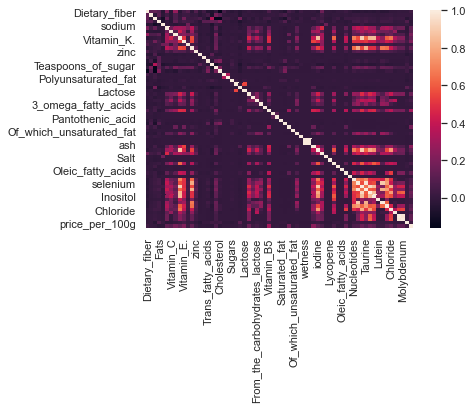

In [33]:
corr_matrix = dfprod.corr()
sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

In [34]:
print(corr_matrix["Vitamin_A"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

Vitamin_A      1.000000
Taurine        0.819951
selenium       0.809348
chlorine       0.677810
Carnitine      0.647247
Nucleotides    0.633712
Vitamin_K.     0.565932
copper         0.546985
Vitamin_E.     0.540874
iodine         0.534325
Inositol       0.494024
Choline        0.490199
Vitamin_D.     0.410959
Chloride       0.406467
phosphorus     0.392029
Name: Vitamin_A, dtype: float64


In [35]:
#dfprod = dfprod.reset_index()
dfprod

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,Inositol,Lutein,chlorine,Carnitine,Chloride,humidity,chromium,Molybdenum,price_per_100g,Partof_vitaminB
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,4.95,0.0
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,1.38,0.0
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,1.65,0.0
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,3.90,0.0
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,25.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,9.86,0.0
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,...,0,0,0,0,0,0,0,0,9.08,0.1
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,6.11,0.0


In [37]:
def variance_threshold_selector(data, threshold=(0.8 * (1 - .8))):
    selector = VarianceThreshold(threshold) #VarianceThreshold removes all low-variance features.
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [38]:
col_fell_thresh = np.array([])
dfprodvar = variance_threshold_selector(dfprod, threshold=(0.8 * (1 - .8)))
for col in dfprod.columns:
    if col not in dfprodvar.columns:
        col_fell_thresh = np.append(col_fell_thresh, col)
print(col_fell_thresh)
dfprod = dfprodvar
dfprod

['Monounsaturated_fat' 'Polyunsaturated_fat' 'Reduced_sodium' 'Lactose'
 'Vitamin_B5' 'Fat_without_trans' 'Pantothenic_acid'
 'Of_which_unsaturated_fat' 'From_sugars_to_organic_acids' 'ash'
 'Lycopene' 'Soluble_fiber' 'Oleic_fatty_acids' 'humidity'
 'Partof_vitaminB']


,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,Taurine,Choline,Inositol,Lutein,chlorine,Carnitine,Chloride,chromium,Molybdenum,price_per_100g
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,4.95
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1.38
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,1.65
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,3.90
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,9.86
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,...,0,0,0,0,0,0,0,0,0,9.08
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,0,6.11


# end of data cleaning

In [39]:
products1 = dfprod.drop("price_per_100g", axis=1)
products_prices1 = dfprod["price_per_100g"].copy()
products2 = dfprod2.drop("price_per_100g", axis=1)
products_prices2 = dfprod2["price_per_100g"].copy()

In [40]:
p1_col = []
p1_index = products1.index.values.tolist()
for col in products1.columns:
    p1_col.append(col)
scaled_features1 = StandardScaler().fit_transform(products1.values)
products_preapered1 = pd.DataFrame(scaled_features1, index=p1_index, columns=p1_col)
p2_col = []
p2_index = products2.index.values.tolist()
for col in products2.columns:
    p2_col.append(col)
scaled_features2 = StandardScaler().fit_transform(products2.values)
products_preapered2 = pd.DataFrame(scaled_features2, index=p2_index, columns=p2_col)

In [41]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(products_preapered1, products_prices1)
some_data = products_preapered1.iloc[69:925]
some_labels = products_prices1.iloc[69:925]
print("predicitions:", lin_reg.predict(some_data))
print("lables:", list(some_labels))
from sklearn.metrics import mean_squared_error
predictions1 = lin_reg.predict(products_preapered1)
lin_mse1 = mean_squared_error(products_prices1, predictions1)
lin_rmse1 = np.sqrt(lin_mse1)
lin_rmse1

predicitions: [ 7.88447861  8.18754778  7.12046236  7.89135948  5.79309381  6.21681687
  7.13741758 13.92046295  6.87218586  7.86178035  7.06501828  9.4879642
  5.47847749  7.14910741  6.34230522  7.44233853  5.3717017   5.27191764
  7.93087633  4.70788285  5.92224949  6.97596703  6.25032983  6.227388
  7.540936    5.95187809 14.88265391  6.34992228  9.02425329  4.42028478
  7.46988404  5.94972741  7.43540117  8.48452238  6.84316587  5.63429296
  5.18746855  8.34856214  6.36823661  7.4234838   4.93973013  8.86404125
  6.81645115  6.59045786  3.6532654   6.26548589  7.76944311  7.03098674
 15.00216436  9.14718512  9.36816956  6.78050217  6.94537233  9.26485236
  7.91779954  6.58630066 14.63588501  6.7022304   5.07181017 15.53408767
  6.93771299  7.02020591  4.13974762  6.89991869  7.38913095  8.49835125
  4.99091364  7.07874734  6.78009294  5.30831634  7.21295108  7.5235621
  8.2314928   6.73771452  7.0472856   5.37177835  7.45979828  7.21029064
  6.81442537  6.82103046  6.73492382  6.3

9.881739563053022

In [42]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(products_preapered2, products_prices2)
some_data = products_preapered2.iloc[69:925]
some_labels = products_prices2.iloc[69:925]
print("predicitions:", lin_reg.predict(some_data))
print("lables:", list(some_labels))
from sklearn.metrics import mean_squared_error
predictions2 = lin_reg.predict(products_preapered2)
lin_mse2 = mean_squared_error(products_prices2, predictions2)
lin_rmse2 = np.sqrt(lin_mse2)
lin_rmse2

predicitions: [ 8.00961658  8.23291353  7.22182746  7.95171768  6.10507561  6.42407681
  7.22178057  5.76057997  6.4333845   7.54018788  7.06747055  9.34617825
  5.79523606  7.13731475  6.38209373  7.21275897  5.58266109  4.93530563
  7.99431309  5.07658006  6.19066514  6.97109187  6.56968679  6.48164107
 10.65871141  6.01342517  5.58618895  6.64668057  8.9207879   4.9297093
  7.71198886  6.50589573  7.76101722  8.5424104   7.0263313   5.70471734
  4.76200734  8.2399037   6.97856461  7.51244718  6.81743057  8.77087276
  6.92592458  6.58826032  4.76704474  6.48368409  7.95240258  7.16362903
  5.55339316  8.98378088  9.48953901  7.04288918  7.18200082  9.05230821
  7.98491209  6.58521405  5.37495142  8.45578835  5.38333222  5.39271893
  7.10185121  7.15540567  3.74190315  6.99562369  7.38407473  8.46509749
  5.81953475  7.18117252  7.01675816  5.34698574  7.31424153  7.85240178
  7.29518854  7.14418758  7.15787936  6.26781456  7.77374548  7.29253599
  6.9729949   6.99246665  6.80348013  

9.967831690062221

In [44]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered1,products_prices1)
predictionst1 = tree_reg.predict(products_preapered1)
tree_mse1 = mean_squared_error(products_prices1, predictionst1)
tree_rmse1 = np.sqrt(tree_mse1)
print(tree_rmse1)

2.380276579253815


In [45]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered2,products_prices2)
predictionst2 = tree_reg.predict(products_preapered2)
tree_mse2 = mean_squared_error(products_prices2, predictionst2)
tree_rmse2 = np.sqrt(tree_mse2)
print(tree_rmse2)

2.3426051032503064


In [ ]:
'''from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered3,products_prices3)
predictionst3 = tree_reg.predict(products_preapered3)
tree_mse = mean_squared_error(products_prices3, predictionst3)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)'''